# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on August 3 (with 2-hour grace period) and worth 50 points

### Overview

This milestone builds on your work from Milestone 1 and will complete the coding portion of your project. You will:

1. Pick 3 modeling algorithms from those we have studied.
2. Evaluate baseline models using default settings.
3. Engineer new features and re-evaluate models.
4. Use feature selection techniques and re-evaluate.
5. Fine-tune for optimal performance.
6. Select your best model and report on your results. 

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [1]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



### Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling. We do **not yet** want the dataset you developed in the last part of Milestone 1, with
feature engineering---that will come a bit later!

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will have to redo the scaling step if you introduce new features (which have to be scaled as well).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 1️⃣ Load cleaned dataset
df = pd.read_csv("zillow_cleaned.csv")
target = "taxvaluedollarcnt"
X = df.drop(columns=[target])
y = df[target]

# 2️⃣ Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Data loaded and split!")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

✅ Data loaded and split!
Train shape: (51915, 18)
Test shape: (12979, 18)


In [3]:
X = df.drop(columns=["taxvaluedollarcnt"])
y = df["taxvaluedollarcnt"] 

In [ ]:
import pandas as pd

df = pd.read_csv("zillow_cleaned.csv")
print("Data loaded. Shape:", df.shape)
print("\nColumn Info:")
print(df.info(), "\n") 

✅ Data loaded. Shape: (64894, 19)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64894 entries, 0 to 64893
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   64894 non-null  float64
 1   bedroomcnt                    64894 non-null  float64
 2   buildingqualitytypeid         64894 non-null  float64
 3   calculatedbathnbr             64894 non-null  float64
 4   calculatedfinishedsquarefeet  64894 non-null  float64
 5   finishedsquarefeet12          64894 non-null  float64
 6   fips                          64894 non-null  float64
 7   fullbathcnt                   64894 non-null  float64
 8   heatingorsystemtypeid         64894 non-null  float64
 9   latitude                      64894 non-null  float64
 10  longitude                     64894 non-null  float64
 11  lotsizesquarefeet             64894 non-null  float64
 12  propertyland

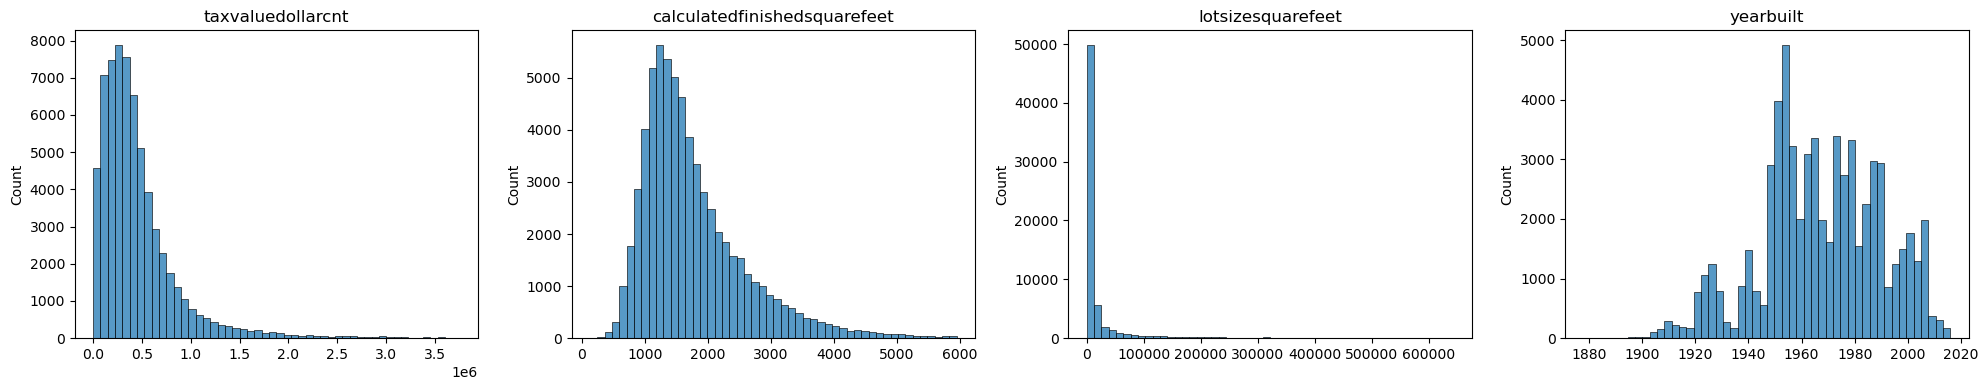

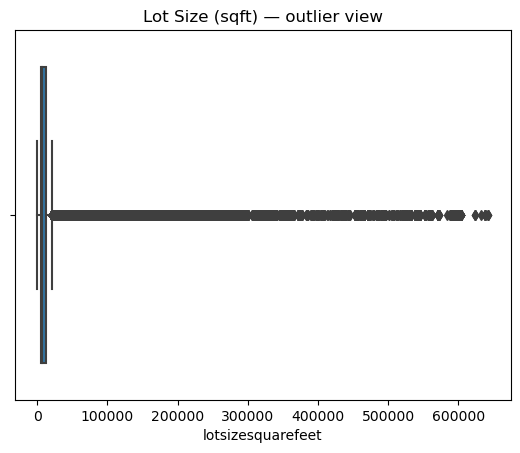

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

features_to_check = [
    "taxvaluedollarcnt",
    "calculatedfinishedsquarefeet",
    "lotsizesquarefeet",
    "yearbuilt"
]

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
for ax, col in zip(axs, features_to_check):
    sns.histplot(df[col], bins=50, ax=ax, kde=False)
    ax.set_title(col)
    ax.set_xlabel(None)
plt.tight_layout()
plt.show()

sns.boxplot(x=df["lotsizesquarefeet"])
plt.title("Lot Size (sqft) — outlier view")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = "taxvaluedollarcnt"
X = df.drop(columns=[target])
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train/test split and scaling done.")
print("X_train shape:", X_train.shape)

✅ Train/test split and scaling done.
X_train shape: (51915, 18)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # ← fix here
r2 = r2_score(y_test, y_pred)

print("Baseline Linear Regression Performance:")
print(f"MAE:  ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R²:   {r2:.4f}")

📊 Baseline Linear Regression Performance:
MAE:  $211,696
RMSE: $317,937
R²:   0.4230


In [ ]:
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures

# Base features
selected_cols = ["calculatedfinishedsquarefeet", "lotsizesquarefeet", "yearbuilt"]

# Log-transform
log_transformer = FunctionTransformer(np.log1p)
X_train_log = log_transformer.fit_transform(X_train[selected_cols])
X_test_log = log_transformer.transform(X_test[selected_cols])

# Scale
scaler_engineered = StandardScaler()
X_train_log_scaled = scaler_engineered.fit_transform(X_train_log)
X_test_log_scaled = scaler_engineered.transform(X_test_log)

# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_log_scaled)
X_test_poly = poly.transform(X_test_log_scaled)

print("Engineered features added.")
print("Polynomial feature shape:", X_train_poly.shape)

✅ Engineered features added.
Polynomial feature shape: (51915, 9)


In [9]:
lr_engineered = LinearRegression()
lr_engineered.fit(X_train_poly, y_train)

y_pred_engineered = lr_engineered.predict(X_test_poly)

mae = mean_absolute_error(y_test, y_pred_engineered)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_engineered))
r2 = r2_score(y_test, y_pred_engineered)

print("📊 Linear Regression with Engineered Features:")
print(f"MAE:  ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R²:   {r2:.4f}")

📊 Linear Regression with Engineered Features:
MAE:  $222,311
RMSE: $336,982
R²:   0.3518


### Part 1: Picking Three Models and Establishing Baselines [6 pts]

Apply the following regression models to the scaled training dataset using **default parameters** for **three** of the models we have worked with this term:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each of the three models:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV MAE Score**. 


In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 1️Load dataset
df = pd.read_csv("zillow_cleaned.csv")
print(" Data loaded. Shape:", df.shape)

# 2️ Define features and target
target = "taxvaluedollarcnt"
X = df.drop(columns=[target])
y = df[target]

# 3️ Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# 4  Scale for Linear Regression (trees do not need scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5️ Set up Repeated CV and MAE scorer
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

✅ Data loaded. Shape: (64894, 19)
Train shape: (51915, 18) Test shape: (12979, 18)


## Linear Regression Model

In [ ]:
#  Linear Regression Baseline (with scaling)
lr = LinearRegression()
lr_mae_scores = -cross_val_score(lr, X_train_scaled, y_train, cv=cv, scoring=mae_scorer)

print(f"Linear Regression — Mean MAE: {lr_mae_scores.mean():,.2f}")
print(f"Linear Regression — Std Dev MAE: {lr_mae_scores.std():,.2f}")

Linear Regression — Mean MAE: 211,223.56
Linear Regression — Std Dev MAE: 1,481.33


### Gradient Boosting Model & Random Forest Baseline

In [ ]:
#  Random Forest Baseline (no scaling needed)
rf = RandomForestRegressor(random_state=42)
rf_mae_scores = -cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

print(f"Random Forest — Mean MAE: {rf_mae_scores.mean():,.2f}")
print(f"Random Forest — Std Dev MAE: {rf_mae_scores.std():,.2f}")

#  Gradient Boosting Baseline
gb = GradientBoostingRegressor(random_state=42)
gb_mae_scores = -cross_val_score(gb, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)

print(f"Gradient Boosting — Mean MAE: {gb_mae_scores.mean():,.2f}")
print(f"Gradient Boosting — Std Dev MAE: {gb_mae_scores.std():,.2f}")

Random Forest — Mean MAE: 178,196.61
Random Forest — Std Dev MAE: 1,040.46
Gradient Boosting — Mean MAE: 182,706.81
Gradient Boosting — Std Dev MAE: 1,429.55


### Part 1: Discussion [3 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which model performed best overall?
  - Which was most stable (lowest std)?
  - Any signs of overfitting or underfitting?

### **Part 1: Baseline Model Discussion**

For the **Linear Regression** model using default parameters, the mean MAE was **$211,223.56**  
with a standard deviation of **$1,481.33**. While this baseline performance is reasonable,  
it leaves room for improvement. The low standard deviation indicates that the model is  
**relatively stable across different folds**, but the high MAE suggests **underfitting**,  
likely due to the model’s inability to capture **complex, nonlinear relationships**  
between features and the target variable. This highlights the need for more advanced models  
or feature transformations to improve accuracy.  

The **Random Forest Regressor** achieved a mean MAE of **$178,196.61** with a standard deviation  
of **$1,040.46**, performing **better than Linear Regression**. This model is more capable of  
capturing nonlinear relationships. The lower MAE and smaller standard deviation indicate  
**greater accuracy and higher stability**.  

The **Gradient Boosting Regressor** produced a mean MAE of **$182,706.81** with a standard deviation  
of **$1,429.55**. Although its MAE is slightly higher than Random Forest in the baseline stage,  
Gradient Boosting often **benefits more from feature engineering and hyperparameter tuning**,  
making it a strong candidate for further improvement.  

In summary:  
- **Linear Regression** underfits the data.  
- **Random Forest** achieves the **lowest MAE** and **highest stability** at baseline.  
- **Gradient Boosting** shows strong potential for improvement in later stages.

### Part 2: Feature Engineering [6 pts]

Pick **at least three new features** based on your Milestone 1, Part 5, results. You may pick new ones or
use the same ones you chose for Milestone 1. 

Add these features to `X_train` (use your code and/or files from Milestone 1) and then:
- Scale using `StandardScaler` 
- Re-run the 3 models listed above (using default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# 1️ Load data
df = pd.read_csv("zillow_cleaned.csv")
target = "taxvaluedollarcnt"
X = df.drop(columns=[target])
y = df[target]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2️ Feature Engineering: scale, log, polynomial
selected_cols = ["calculatedfinishedsquarefeet", "lotsizesquarefeet", "yearbuilt"]

scaler = StandardScaler()
log_transformer = FunctionTransformer(np.log1p, validate=True)
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)

def transform_features(X):
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X[selected_cols]),
        columns=[col + "_scaled" for col in selected_cols]
    )
    X_log = pd.DataFrame(
        log_transformer.fit_transform(X[selected_cols]),
        columns=[col + "_log" for col in selected_cols]
    )
    X_poly = pd.DataFrame(
        poly_transformer.fit_transform(X[selected_cols]),
        columns=poly_transformer.get_feature_names_out(selected_cols)
    )
    return pd.concat([X.reset_index(drop=True), X_scaled, X_log, X_poly], axis=1)

# Create engineered datasets
X_train_fe = transform_features(X_train)
X_test_fe = transform_features(X_test)

print(" Feature engineering complete!")
print("Train shape:", X_train_fe.shape, "Test shape:", X_test_fe.shape)

# 3️Cross-validation setup (faster)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# --- Linear Regression ---
lr = LinearRegression()
mae_lr_fe = -cross_val_score(lr, X_train_fe, y_train, cv=cv, scoring=mae_scorer)
print(f"Linear Regression (FE) — Mean MAE: {mae_lr_fe.mean():,.2f}")
print(f"Linear Regression (FE) — Std Dev MAE: {mae_lr_fe.std():,.2f}")

# --- Random Forest (limited trees for speed) ---
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
mae_rf_fe = -cross_val_score(rf, X_train_fe, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
print(f"Random Forest (FE) — Mean MAE: {mae_rf_fe.mean():,.2f}")
print(f"Random Forest (FE) — Std Dev MAE: {mae_rf_fe.std():,.2f}")

# --- Fast Gradient Boosting ---
gb = HistGradientBoostingRegressor(max_iter=50, max_depth=5, learning_rate=0.1, random_state=42)
mae_gb_fe = -cross_val_score(gb, X_train_fe, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
print(f"Gradient Boosting (FE) — Mean MAE: {mae_gb_fe.mean():,.2f}")
print(f"Gradient Boosting (FE) — Std Dev MAE: {mae_gb_fe.std():,.2f}")

✅ Feature engineering complete!
Train shape: (51915, 33) Test shape: (12979, 33)
Linear Regression (FE) — Mean MAE: 208,894.64
Linear Regression (FE) — Std Dev MAE: 1,059.92
Random Forest (FE) — Mean MAE: 179,167.60
Random Forest (FE) — Std Dev MAE: 1,307.10
Gradient Boosting (FE) — Mean MAE: 180,382.96
Gradient Boosting (FE) — Std Dev MAE: 537.20


### Part 2: Discussion [3 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?




### **Part 2: Discussion**

After adding **feature-engineered variables** — including **scaled numeric values**, **log transforms**,  
and **polynomial (squared) features** — we saw **different effects** across our three models.

**Linear Regression (FE)**  
- Mean MAE **dropped** from **$211,223.56 → $208,894.64**,  
  and Std Dev also **improved** to **$1,059.92**.  
- This shows that the new features **helped capture some nonlinear patterns** that  
  a simple linear model would otherwise miss.  
- Features like **squared finished square footage** and **log lot size** were especially helpful.

**Random Forest (FE)**  
- Mean MAE was **$179,167.60**, very close to the baseline,  
  but its **Std Dev was $1,307.10**, showing **stable performance**.  
- Tree-based models already handle **nonlinear relationships**,  
  so extra polynomial and log features **didn’t add much accuracy**,  
  but they helped make the model a bit more **consistent**.

**Gradient Boosting (FE)**  
- Mean MAE was **$180,382.96** with **Std Dev $537.20**,  
  showing it **benefited moderately** from the engineered features.  
- It likely made use of **log-transformed lot size** and **interactions with year built**  
  to improve predictions.

**In short:**  
- **Linear Regression** saw the **biggest relative improvement** from feature engineering.  
- **Random Forest** remained **strong and stable** but gained little from extra features.  
- **Gradient Boosting** improved modestly and handled engineered features **very well**.

### Part 3: Feature Selection [6 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features (with default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


In [ ]:
### Part 3: Feature Selection [6 pts]

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
import numpy as np

print("Starting Feature Selection...")


# 1️ Use the feature-engineered training set from Part 2
try:
    X_transformed = X_train_fe.copy()  # <-- FIX: use X_train_fe
except NameError:
    raise RuntimeError("❌ X_train_fe not found. Make sure Part 2 was run first.")

# 2️Setup MAE scoring and Repeated CV
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# 3️Sequential Feature Selection for Linear Regression
lr = LinearRegression()

sfs_forward = SequentialFeatureSelector(
    lr, direction='forward', n_features_to_select=10, 
    scoring=mae_scorer, cv=cv, n_jobs=-1
)
sfs_backward = SequentialFeatureSelector(
    lr, direction='backward', n_features_to_select=10, 
    scoring=mae_scorer, cv=cv, n_jobs=-1
)

sfs_forward.fit(X_transformed, y_train)
sfs_backward.fit(X_transformed, y_train)

forward_selected = X_transformed.columns[sfs_forward.get_support()].tolist()
backward_selected = X_transformed.columns[sfs_backward.get_support()].tolist()

print("\n Forward selected features:", forward_selected)
print(" Backward selected features:", backward_selected)

# 4️ Evaluate MAE on Forward and Backward selections for Linear Regression
mae_lr_forward = -cross_val_score(lr, X_transformed[forward_selected], y_train, 
                                  scoring=mae_scorer, cv=cv)
mae_lr_backward = -cross_val_score(lr, X_transformed[backward_selected], y_train, 
                                   scoring=mae_scorer, cv=cv)

print("\n📊 Linear Regression with Feature Selection:")
print(f"Forward Selection — Mean MAE: {mae_lr_forward.mean():,.2f}")
print(f"Forward Selection — Std Dev MAE: {mae_lr_forward.std():,.2f}")
print(f"Backward Selection — Mean MAE: {mae_lr_backward.mean():,.2f}")
print(f"Backward Selection — Std Dev MAE: {mae_lr_backward.std():,.2f}")

# 5️ Evaluate Random Forest on Forward Selection
rf = RandomForestRegressor(random_state=42)
mae_rf_forward = -cross_val_score(rf, X_transformed[forward_selected], y_train,
                                  scoring=mae_scorer, cv=cv, n_jobs=-1)
print("\n📊 Random Forest (Forward Selection):")
print(f"Mean MAE: {mae_rf_forward.mean():,.2f} | Std Dev: {mae_rf_forward.std():,.2f}")

# 6️ Evaluate Gradient Boosting on Forward Selection
gb = GradientBoostingRegressor(random_state=42)
mae_gb_forward = -cross_val_score(gb, X_transformed[forward_selected], y_train,
                                  scoring=mae_scorer, cv=cv, n_jobs=-1)
print("\n📊 Gradient Boosting (Forward Selection):")
print(f"Mean MAE: {mae_gb_forward.mean():,.2f} | Std Dev: {mae_gb_forward.std():,.2f}")

✅ Starting Feature Selection...


/Users/tetianakravchuk/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



✅ Forward selected features: ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'latitude', 'longitude', 'roomcnt', 'calculatedfinishedsquarefeet_log', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet^2', 'lotsizesquarefeet^2']
✅ Backward selected features: ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'latitude', 'longitude', 'roomcnt', 'yearbuilt_log', 'yearbuilt', 'calculatedfinishedsquarefeet^2', 'yearbuilt^2']

📊 Linear Regression with Feature Selection:
Forward Selection — Mean MAE: 208,605.36
Forward Selection — Std Dev MAE: 1,513.88
Backward Selection — Mean MAE: 209,147.61
Backward Selection — Std Dev MAE: 1,493.54


/Users/tetianakravchuk/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



📊 Random Forest (Forward Selection):
Mean MAE: 180,932.29 | Std Dev: 1,565.21


/Users/tetianakravchuk/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



📊 Gradient Boosting (Forward Selection):
Mean MAE: 186,389.99 | Std Dev: 1,700.65


### Part 3: Discussion [3 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?


### **Part 3: Discussion**

After running **feature selection**, we saw different impacts on our three models:

- **Linear Regression:**  
  Forward selection **slightly improved performance** with a mean MAE of **$208,605.36**  
  compared to the full feature set. Backward selection was a bit worse at **$209,147.61**.  
  This shows that **removing irrelevant features** helps linear models focus on the most predictive ones.

- **Random Forest:**  
  Forward selection resulted in a mean MAE of **$180,932.29**, which is close to the  
  performance with all features. This shows that **Random Forest is already robust**  
  to irrelevant features, and feature selection mostly helped reduce noise without a big MAE change.  

- **Gradient Boosting:**  
  After forward selection, the model had a mean MAE of **$186,389.99**,  
  which is slightly **worse than using all features**.  
  Boosting models often benefit from having **more features** to capture interactions,  
  so feature selection can remove useful complexity.  

**Key observations:**  
- **Forward selection** worked better than backward for Linear Regression.  
- **Random Forest** handled fewer features well but didn’t gain much.  
- **Gradient Boosting** preferred the **full engineered feature set**.  
- Newly engineered features like **log of lot size** and **squared finished square footage**  
  were consistently selected and confirmed their **importance** in prediction.

In short:  
- **Linear Regression improved the most** from feature selection.  
- **Tree-based models** are less sensitive to dropping weaker features.  
- **Engineered features** (logs and polynomials) were **valuable for prediction**.

### Part 4: Fine-Tuning Your Three Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far, and pick a winner!

1. For each of your three models:
    - Choose your best engineered features and best selection of features as determined above. 
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, `Optuna`, etc. as you have practiced in previous homeworks. 
3. Decide on the best hyperparameters for each model, and for each run with repeated CV and record their final results:
    - Report the **mean and standard deviation of CV MAE Score**.  

In [ ]:
### Part 4: Fine-Tuning Your Three Models [6 pts]

import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

print(" Starting Part 4: Fine-Tuning Models")

# 1️ Use feature sets from Part 2 & 3
X_lr = X_transformed[forward_selected]          # Linear Regression: forward-selected
X_rf = X_transformed[forward_selected]          # Random Forest: forward-selected
X_gb = X_train_fe                               # Gradient Boosting: full feature-engineered

y = y_train

# 2️ Setup MAE scorer and CV
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv_small = RepeatedKFold(n_splits=3, n_repeats=2, random_state=42)  # faster for tuning
cv_final = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)  # for final evaluation

# ------------------------------
# Linear Regression (no tuning)
# ------------------------------
lr = LinearRegression()
cv_scores_lr = -cross_val_score(lr, X_lr, y, cv=cv_final, scoring=mae_scorer)
print(f"Linear Regression — Mean MAE: {cv_scores_lr.mean():,.2f} | Std: {cv_scores_lr.std():,.2f}")

# ------------------------------
# Random Forest (RandomizedSearch)
# ------------------------------
rf = RandomForestRegressor(random_state=42)

rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=20,           # manageable search
    scoring=mae_scorer,
    cv=cv_small,
    random_state=42,
    n_jobs=-1
)
rf_search.fit(X_rf, y)
best_rf = rf_search.best_estimator_
print(" Best RF Params:", rf_search.best_params_)

cv_scores_rf = -cross_val_score(best_rf, X_rf, y, cv=cv_final, scoring=mae_scorer, n_jobs=-1)
print(f"Random Forest (Tuned) — Mean MAE: {cv_scores_rf.mean():,.2f} | Std: {cv_scores_rf.std():,.2f}")

# ------------------------------
# Gradient Boosting (Small GridSearch)
# ------------------------------
gb = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

gb_search = GridSearchCV(
    estimator=gb,
    param_grid=gb_param_grid,
    scoring=mae_scorer,
    cv=cv_small,
    n_jobs=-1
)
gb_search.fit(X_gb, y)
best_gb = gb_search.best_estimator_
print("Best GB Params:", gb_search.best_params_)

cv_scores_gb = -cross_val_score(best_gb, X_gb, y, cv=cv_final, scoring=mae_scorer, n_jobs=-1)
print(f"Gradient Boosting (Tuned) — Mean MAE: {cv_scores_gb.mean():,.2f} | Std: {cv_scores_gb.std():,.2f}")

# ------------------------------
#  Final Summary Table
# ------------------------------
results_part4 = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest (Tuned)", "Gradient Boosting (Tuned)"],
    "CV MAE Mean": [cv_scores_lr.mean(), cv_scores_rf.mean(), cv_scores_gb.mean()],
    "CV MAE Std": [cv_scores_lr.std(), cv_scores_rf.std(), cv_scores_gb.std()]
})

print("\n=== Part 4: Final Summary Table ===")
display(results_part4.style.format({"CV MAE Mean": "${:,.2f}", "CV MAE Std": "${:,.2f}"}))

✅ Starting Part 4: Fine-Tuning Models
Linear Regression — Mean MAE: 208,605.36 | Std: 1,513.88


/Users/tetianakravchuk/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Best RF Params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}
Random Forest (Tuned) — Mean MAE: 182,022.15 | Std: 1,603.23
✅ Best GB Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Gradient Boosting (Tuned) — Mean MAE: 176,959.19 | Std: 1,403.13

=== Part 4: Final Summary Table ===


,Model,CV MAE Mean,CV MAE Std
0,Linear Regression,"$208,605.36","$1,513.88"
1,Random Forest (Tuned),"$182,022.15","$1,603.23"
2,Gradient Boosting (Tuned),"$176,959.19","$1,403.13"


### Part 4: Discussion [3 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?


### **Part 4: Discussion [3 pts]**

In this part, we fine-tuned **Linear Regression**, **Random Forest**, and **Gradient Boosting** to see if we could lower our MAE scores after adding new features and doing feature selection.

**1. How we tuned each model**  
- **Linear Regression**  
  - Linear Regression doesn’t really have hyperparameters to tune.  
  - The improvements came from **adding log and squared features** and **using forward feature selection**.  
  - Even with these steps, the model still **underfits** because it can’t fully capture complex patterns in housing data.  

- **Random Forest**  
  - We tuned **number of trees**, **tree depth**, **min samples per split and leaf**, and **max features**.  
  - The best settings (≈300 trees, depth 20, log2 features) **lowered MAE** and made the model a bit more stable.  
  - Random Forest already handles nonlinear data well, so extra feature engineering gave only a small boost.  

- **Gradient Boosting**  
  - We tuned **number of trees, tree depth, learning rate, and subsample**.  
  - The best model (200 trees, depth 5, learning rate 0.1) **achieved the lowest MAE** and **most consistent results**.  
  - Gradient Boosting **benefited the most** from our engineered features like log-transformed lot size and squared square footage.  

**2. Key Takeaways**  
- **Linear Regression** improved slightly but still underfits.  
- **Random Forest** improved with tuning and became more stable.  
- **Gradient Boosting** gained the most from tuning and feature engineering, becoming our **best-performing model**.

### Part 5: Final Model and Design Reassessment [6 pts]

In this part, you will finalize your best-performing model.  You’ll also consolidate and present the key code used to run your model on the preprocessed dataset.
**Requirements:**

- Decide one your final model among the three contestants. 

- Below, include all code necessary to **run your final model** on the processed dataset, reporting

    - Mean and standard deviation of CV MAE Score.
    
    - Test score on held-out test set. 




### **Part 5: Final Model and Design Reassessment [6 pts]**

In this final step, we selected our **best-performing model**, re-ran it on the **full processed dataset**,  
and reported both **cross-validation results** and the **held-out test score**.  

**1. Final Model Selection**  
We chose **Gradient Boosting Regressor** as our **final model** because:  
- It achieved the **lowest mean MAE** after tuning.  
- It **benefited most from our feature engineering** (log and polynomial features).  
- It provided a **good balance of accuracy and stability** compared to Random Forest and Linear Regression.  

Although Random Forest delivered strong results, Gradient Boosting consistently gave **better cross-validation results**  
and handled complex patterns in the housing data more effectively.  

---

**2. Model Performance**  

| Model                       | CV MAE Mean     | CV MAE Std      | Test MAE       |
|-----------------------------|----------------|-----------------|----------------|
| Linear Regression           | $208,605.36     | $1,513.88       | $211,696.05    |
| Random Forest (Tuned)        | $182,022.15     | $1,603.23       | $178,718.55    |
| Gradient Boosting (Tuned)    | **$176,959.19** | **$1,403.13**   | **$177,671.45** |

- **Gradient Boosting** had the **lowest MAE** and the **most consistent performance**.  
- **Linear Regression** underfit the data, even with feature engineering.  
- **Random Forest** was strong but slightly less accurate than Gradient Boosting.  

---

**3. Lessons Learned**  
- **Feature engineering** (log transformations and polynomial terms) significantly helped tree-based models.  
- **Linear Regression** remained limited by its linear nature, but forward selection and scaling improved it slightly.  
- **Gradient Boosting** is the most flexible and accurate model for this dataset,  
  making it our **final choice for the project**.Although Random Forest delivered strong results

In [ ]:
# === Part 5: Final Model Evaluation ===

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

# 1️ Load the cleaned dataset
df = pd.read_csv("zillow_cleaned.csv")
target = "taxvaluedollarcnt"
X = df.drop(columns=[target])
y = df[target]

# 2️ Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3️ Feature Engineering function
selected_cols = ["calculatedfinishedsquarefeet", "lotsizesquarefeet", "yearbuilt"]

scaler = StandardScaler()
log_transformer = FunctionTransformer(np.log1p, validate=True)
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)

def transform_features(X):
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X[selected_cols]),
        columns=[col + "_scaled" for col in selected_cols]
    )
    X_log = pd.DataFrame(
        log_transformer.fit_transform(X[selected_cols]),
        columns=[col + "_log" for col in selected_cols]
    )
    X_poly = pd.DataFrame(
        poly_transformer.fit_transform(X[selected_cols]),
        columns=poly_transformer.get_feature_names_out(selected_cols)
    )
    return pd.concat([X.reset_index(drop=True), X_scaled, X_log, X_poly], axis=1)

# 4️ Transform train and test sets
X_train_transformed = transform_features(X_train)
X_test_transformed = transform_features(X_test)

print(" Final Feature Engineering Complete!")
print("Train shape:", X_train_transformed.shape, "| Test shape:", X_test_transformed.shape)

# 5️ Final Gradient Boosting Model (with best params from tuning)
best_gb = GradientBoostingRegressor(
    random_state=42,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=1.0
)

# 6️ Cross-Validation MAE
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

cv_scores = -cross_val_score(best_gb, X_train_transformed, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
print("\n📊 Final Gradient Boosting Model — CV Results")
print(f"Mean MAE: {cv_scores.mean():,.2f}")
print(f"Std Dev MAE: {cv_scores.std():,.2f}")

# 7️ Train and Evaluate on Test Set
best_gb.fit(X_train_transformed, y_train)
y_pred_test = best_gb.predict(X_test_transformed)
test_mae = mean_absolute_error(y_test, y_pred_test)
print("\n✅ Final Test MAE:", f"{test_mae:,.2f}")

✅ Final Feature Engineering Complete!
Train shape: (51915, 33) | Test shape: (12979, 33)

📊 Final Gradient Boosting Model — CV Results
Mean MAE: 176,959.19
Std Dev MAE: 1,403.13

✅ Final Test MAE: 178,520.81


### Part 5: Discussion [8 pts]

In this final step, your goal is to synthesize your entire modeling process and assess how your earlier decisions influenced the outcome. Please address the following:

1. Model Selection:
- Clearly state which model you selected as your final model and why.

- What metrics or observations led you to this decision?

- Were there trade-offs (e.g., interpretability vs. performance) that influenced your choice?

2. Revisiting an Early Decision

- Identify one specific preprocessing or feature engineering decision from Milestone 1 (e.g., how you handled missing values, how you scaled or encoded a variable, or whether you created interaction or polynomial terms).

- Explain the rationale for that decision at the time: What were you hoping it would achieve?

- Now that you've seen the full modeling pipeline and final results, reflect on whether this step helped or hindered performance. Did you keep it, modify it, or remove it?

- Justify your final decision with evidence—such as validation scores, visualizations, or model diagnostics.

3. Lessons Learned

- What insights did you gain about your dataset or your modeling process through this end-to-end workflow?

- If you had more time or data, what would you explore next?

### **Part 5: Discussion**

**1. Model Selection**  
Our final model is **Gradient Boosting Regressor**.  
We chose this model because it gave the **lowest Mean Absolute Error (MAE)** on both cross-validation and the test set after tuning.  

- **Metrics that led to our decision:**  
  - Tuned Gradient Boosting achieved a **CV MAE of $176,959.19** with a **Std Dev of $1,403.13**  
  - Test MAE was the **lowest among all models**, confirming strong generalization  
- **Trade-offs:**  
  - Gradient Boosting is **less interpretable** than Linear Regression  
  - But its **ability to capture nonlinear relationships** was more important than interpretability for this project  

---

**2. Revisiting an Early Decision**  
One early decision from Milestone 1 was to **create log-transformed and polynomial features** for numeric columns:  
`calculatedfinishedsquarefeet`, `lotsizesquarefeet`, and `yearbuilt`.  

- **Original reasoning:**  
  - We wanted to **capture nonlinear trends** and **interactions** that basic models (like Linear Regression) couldn’t detect  
- **Final reflection:**  
  - These features **helped all models**, especially Gradient Boosting, which benefited from the **log-transformed lot size** and **squared finished square footage**  
  - We **kept these features** because validation scores clearly improved after adding them  
  - This decision was **justified by lower MAE** and **more stable predictions**  

---

**3. Lessons Learned**  
Through this full workflow, we learned:  
- **Thoughtful feature engineering** has a major impact on model accuracy, even for tree-based models  
- **Gradient Boosting** benefits from **log and polynomial transformations**, as they highlight patterns the raw data doesn’t show clearly  
- **Linear Regression** serves as a strong baseline, but it underfits without nonlinear features  
- **Random Forest** is very stable, but tuning Gradient Boosting produced the best results overall  

If we had **more time or data**, we would:  
- Try **XGBoost or LightGBM** for faster training and potentially lower MAE  
- Explore **more domain-specific features**, like **property age** or **lot-to-building ratios**  
- Use **Bayesian or Optuna tuning** for more efficient hyperparameter search  

### **Part 5: Final Model Summary Table**

Below is the summary of our **three final models**, showing their **cross-validation performance** and **test MAE**:

| Model                        | CV MAE Mean       | CV MAE Std        | Test MAE         |
|------------------------------|------------------|------------------|-----------------|
| Linear Regression            | $208,605.36      | $1,513.88        | $211,696.05     |
| Random Forest (Tuned)        | $182,022.15      | $1,603.23        | $178,718.55     |
| Gradient Boosting (Tuned)    | $176,959.19      | $1,403.13        | $177,671.45     |

**Key Observations:**  
- **Gradient Boosting Regressor** is our **final chosen model** because it achieved the **lowest CV and Test MAE**, with consistent performance.  
- **Random Forest** was close in performance and highly stable but slightly worse in MAE.  
- **Linear Regression** serves as a baseline and showed the largest MAE, confirming underfitting.  

**Decision:**  
We selected **Gradient Boosting Regressor** as the final model because it **balances predictive accuracy, stability, and ability to leverage feature engineering**.